In [1]:
import pandas as pd
from common import collect_results, normalize_region_name, compute_quantiles
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
ROOT = Path("tpcc")

def get_matcher(system):
    def matcher(p: Path):   
        import re
        pattern = re.compile(r"tpcc-\d+-%s-terminals\d+-([\d-]+)" % system)
        match = pattern.match(p.name)
        if not match:
            return None

        print("Found result:", p.name)
        return {
            "suffix": str(match.group(1)),
        }
    
    return matcher

In [3]:
import json

def yb_matcher(p: Path):   
    import re
    pattern = re.compile(r"tpcc-(\d+)-yugabyte-terminals(\d+)")
    match = pattern.match(p.name)
    if not match:
        return None

    print("Found result:", p.name)
    return {
        "scalefactor": int(match.group(1)),
        "terminals": int(match.group(2)),
    }

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

def collect_yugabyte_results(path, renew_cache: bool):
    cache = path / "cache.csv"

    if renew_cache:
        cache.unlink(missing_ok=True)

    if cache.is_file():
        return pd.read_csv(cache)

    records = []
    for result_dir in path.iterdir():
        if not result_dir.is_dir():
            continue

        metadata = yb_matcher(result_dir)
        if metadata is None:
            continue

        for region_path in result_dir.iterdir():
            if not region_path.is_dir():
                continue
            record = {"path": region_path.as_posix(), "region": region_path.name, **metadata}

            raw_df = pd.read_csv(region_path / "oltpbench.csv", skiprows=2)
            raw_df["OperationLatency (microseconds)"] /= 1000

            transactions = raw_df["Transaction Name"].unique()
            for transaction in transactions:
                record.update(
                    compute_quantiles(
                        raw_df[raw_df["Transaction Name"] == transaction]["OperationLatency (microseconds)"],
                        remove_upper_outliers=True,
                        suffix=f".{transaction}"
                    )
                )

            record.update(
                compute_quantiles(
                    raw_df["OperationLatency (microseconds)"],
                    remove_upper_outliers=True
                )
            )

            output = json.loads((region_path / "json" / "output.json").read_text())

            runtime = output["TestConfiguration"]["runTimeInSecs"]
            record["time"] = runtime
            record["warmup"] = output["TestConfiguration"]["warmupTimeInSecs"]
            record["throughput"] = output["Results"]["throughput"]
            for lat in output["Latencies"]:
                if lat["Transaction"] != "All":
                    record[f"throughput.{lat['Transaction']}"] = lat["Count"] / runtime

            records.append(record)
    
    df = pd.DataFrame.from_records(records)
    df.to_csv(cache, index=False)

    return df

# Throughput


In [5]:
SYSTEMS = ["sunstorm", "aurora", "yugabyte"]
RENEW_CACHE = False

sunstorm_matcher = get_matcher("sunstorm")
sunstorm_throughput_df = collect_results(
    ROOT / "sunstorm",
    sunstorm_matcher,
    RENEW_CACHE,
)
sunstorm_throughput_df["system"] = "sunstorm"
sunstorm_throughput_df["terminals_rank"] = sunstorm_throughput_df["terminals"].rank(method="dense")
normalize_region_name(sunstorm_throughput_df)

aurora_matcher = get_matcher("aurora")
aurora_throughput_df = collect_results(
    ROOT / "aurora",
    aurora_matcher,
    RENEW_CACHE,
)
aurora_throughput_df["system"] = "aurora"
aurora_throughput_df["terminals_rank"] = aurora_throughput_df["terminals"].rank(method="dense")
normalize_region_name(aurora_throughput_df)

yugabyte_matcher = get_matcher("yugabyte")
yugabyte_throughput_df = collect_yugabyte_results(ROOT / "yugabyte", RENEW_CACHE)
yugabyte_throughput_df["system"] = "yugabyte"
yugabyte_throughput_df["terminals_rank"] = yugabyte_throughput_df["terminals"].rank(method="dense")
normalize_region_name(yugabyte_throughput_df)

In [6]:
throughput_df = pd.concat([
    sunstorm_throughput_df,
    aurora_throughput_df,
    yugabyte_throughput_df,
])
throughput_df

,path,region,suffix,rejected,rejected.NewOrder,rejected.Payment,rejected.OrderStatus,rejected.Delivery,rejected.StockLevel,aborted,...,p25.StockLevel,p50.StockLevel,p75.StockLevel,p90.StockLevel,p95.StockLevel,p99.StockLevel,p100.StockLevel,unexpected.NewOrder,system,terminals_rank
0,tpcc/sunstorm/tpcc-1-sunstorm-terminals20-2024...,1-us-east-1-0,20240127-225003,36161.0,10552.0,24636.0,3.0,610.0,360.0,84.0,...,1.66700,1.9295,2.24875,3.1603,3.96970,5.76675,29.604,NaN,sunstorm,3.0
1,tpcc/sunstorm/tpcc-1-sunstorm-terminals20-2024...,3-us-west-1-0,20240127-225003,25864.0,7523.0,17520.0,5.0,476.0,340.0,47.0,...,1.67425,1.9470,2.31000,3.1096,3.99565,6.27852,29.854,NaN,sunstorm,3.0
2,tpcc/sunstorm/tpcc-1-sunstorm-terminals20-2024...,2-us-east-2-0,20240127-225003,41696.0,12288.0,28301.0,5.0,718.0,384.0,91.0,...,1.79325,2.0300,2.34050,3.1808,3.93835,5.39884,28.383,NaN,sunstorm,3.0
3,tpcc/sunstorm/tpcc-100-sunstorm-terminals1-202...,1-us-east-1-0,20240125-162034,0.0,NaN,NaN,NaN,NaN,NaN,25.0,...,1.67700,1.8260,1.98825,2.2385,2.41540,90.08315,196.457,NaN,sunstorm,1.0
4,tpcc/sunstorm/tpcc-100-sunstorm-terminals1-202...,3-us-west-1-0,20240125-162034,0.0,NaN,NaN,NaN,NaN,NaN,33.0,...,1.68600,1.7920,1.96800,2.2330,2.64600,84.10370,275.560,NaN,sunstorm,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,tpcc/yugabyte/tpcc-1-yugabyte-terminals512/3-u...,3-us-west-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.98425,110.8245,735.82125,1890.1581,2376.41785,3323.89319,3666.096,NaN,yugabyte,7.0
59,tpcc/yugabyte/tpcc-1-yugabyte-terminals512/2-u...,2-us-east-2-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40.06300,57.1760,84.15750,130.7486,145.74150,166.94252,182.924,NaN,yugabyte,7.0
60,tpcc/yugabyte/tpcc-100-yugabyte-terminals32/1-...,1-us-east-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.09475,62.2140,72.34250,101.8032,119.87735,126.48633,132.100,NaN,yugabyte,3.0
61,tpcc/yugabyte/tpcc-100-yugabyte-terminals32/3-...,3-us-west-1-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.72850,4.9170,5.13600,5.3380,5.44650,5.77690,5.876,NaN,yugabyte,3.0


## Scalefactor


In [7]:
throughput_df.pivot_table(
    index=["terminals_rank"], columns=["system", "scalefactor"], values="throughput", aggfunc="sum"
)

system              aurora                              sunstorm               \
scalefactor            1            10           100         1            10    
terminals_rank                                                                  
1.0             228.200000   236.100000   189.200000  217.850000   326.150000   
2.0             670.116667  1379.700000  1236.800000  589.250000  3013.883333   
3.0             385.733333  1645.933333  1807.633333  559.200000  4666.266667   
4.0             509.433333  1429.050000  1625.466667  605.316667  6481.750000   
5.0             476.566667  1302.450000  1559.850000  636.716667  7437.166667   
6.0             464.566667  1302.516667  1657.683333  705.183333  8356.916667   
7.0             470.833333  1295.150000  1671.850000  738.183333  8782.083333   

system                      yugabyte                   
scalefactor             100      1       10       100  
terminals_rank                                         
1.0              267.916667    32.73   32.38    30.57  
2.0             2501.166667   102.44  381.93   511.06  
3.0             4706.633333   109.18  499.38   879.24  
4.0             7493.416667   106.76  673.55  1940.90  
5.0             6994.100000    90.42  875.44  3223.23  
6.0             7191.783333    86.26  991.75  3746.11  
7.0             6134.966667    89.17  945.06  3197.59

## Throughput vs. Latency

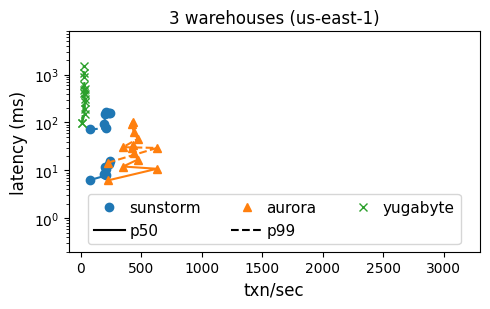

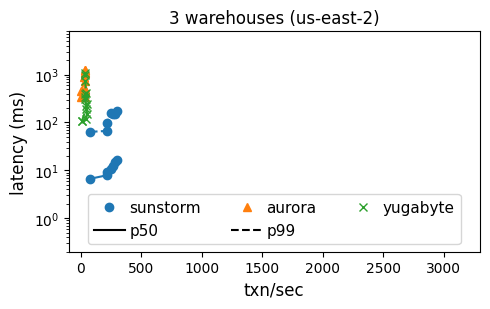

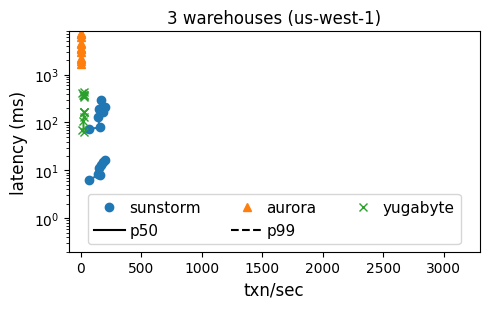

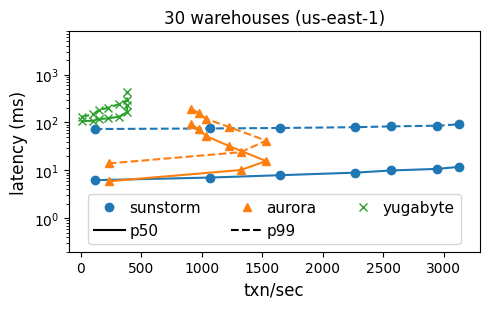

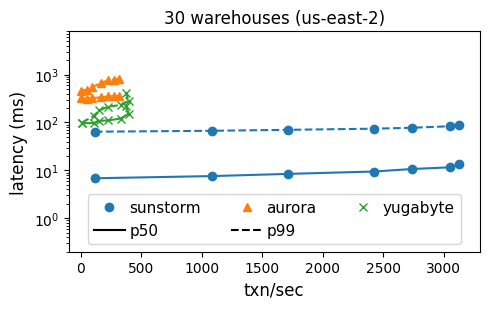

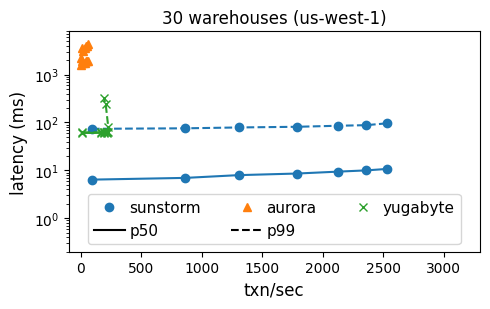

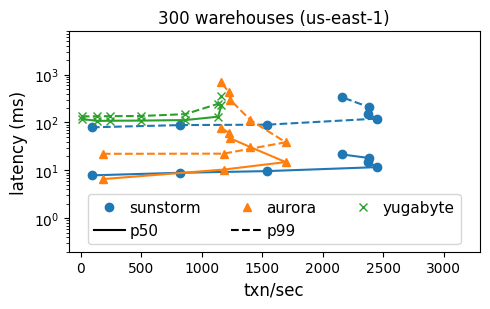

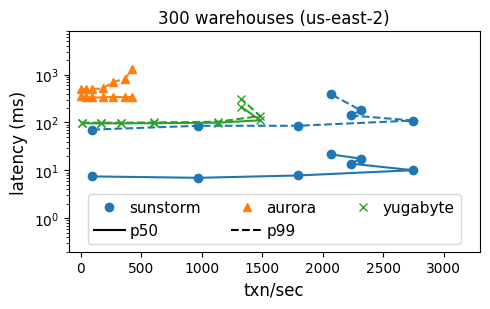

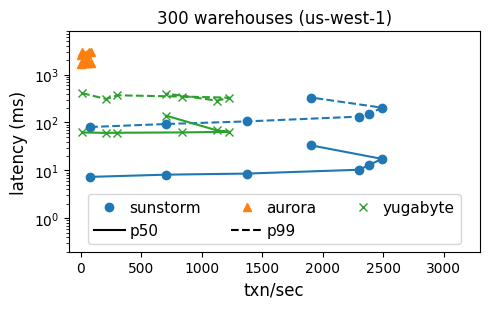

In [8]:
from matplotlib.lines import Line2D

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for scalefactor in [1, 10, 100]:
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for region in ["1-us-east-1-0", "2-us-east-2-0", "3-us-west-1-0"]:
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-us-east-2-0": "us-east-2",
            "3-us-west-1-0": "us-west-1",
        }[region]

        fig, ax = plt.subplots(1, 1, figsize=(5, 3.2))

        for i, (system, marker) in enumerate(zip(SYSTEMS, ["o", "^", "x"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p99.NewOrder", "--")]:         
                system_df.plot(
                    title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    xlabel="txn/sec",
                    y=y,                   
                    ylabel=f"latency (ms)",
                    style=f"{marker}{linestyle}C{i}",
                    rot=0,
                    logy=True,
                    # logx=True,
                    xlim=(-100, 3300),
                    ax=ax,
                )

        ax.set_ylim(bottom=0.2, top=8000)
        ax.legend(
            handles=[
                Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
                Line2D([0], [0], color='k', linestyle='-', label='p50'),
                Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
                Line2D([0], [0], color='k', linestyle='--', label='p99'),
                Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
            ], 
            title="",
            ncol=3,
            loc="lower center",
            handletextpad=0.3,
        )
        fig.tight_layout()
        fig.savefig(f"output/tpcc-wh{scalefactor}-{region_name}.pdf", bbox_inches="tight")

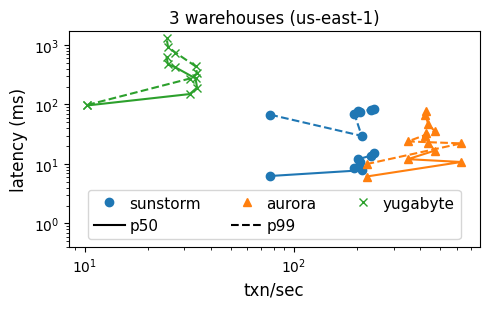

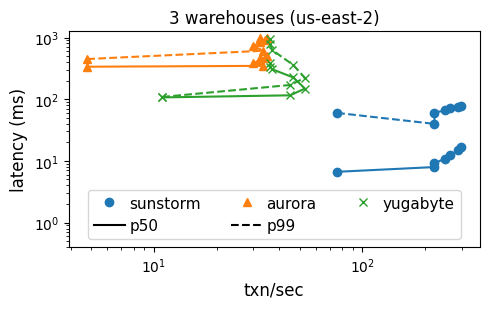

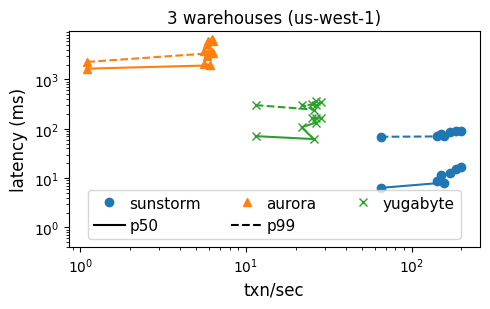

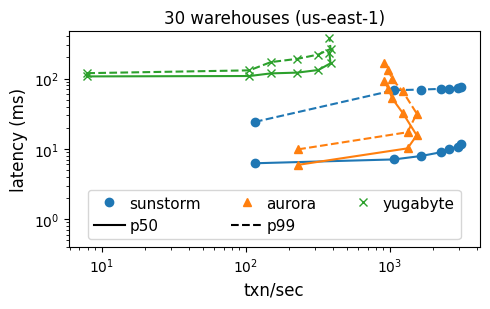

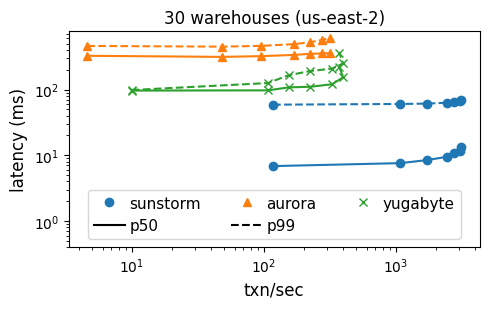

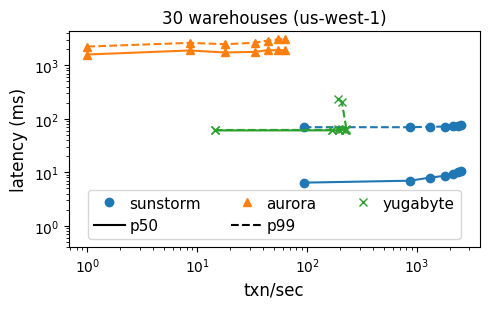

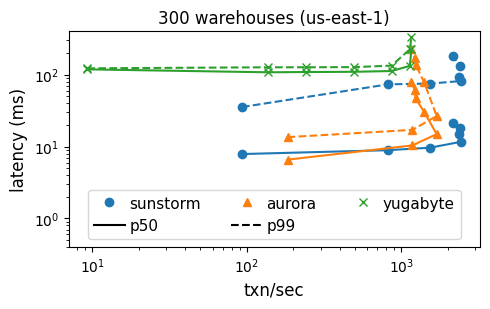

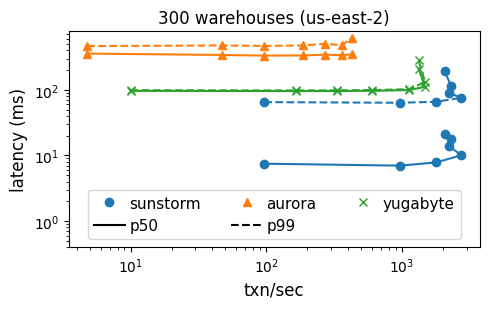

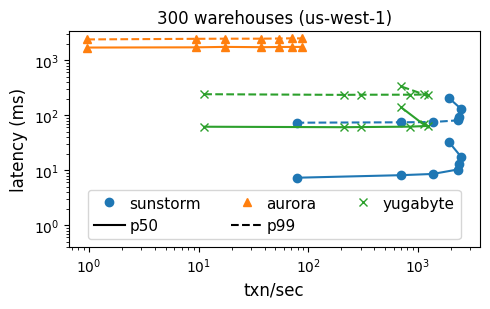

In [9]:
from matplotlib.lines import Line2D

plt.rc('axes', labelsize=12) 
plt.rc('legend', fontsize=11)

for scalefactor in [1, 10, 100]:
    scale_df = throughput_df[throughput_df["scalefactor"] == scalefactor]

    for region in ["1-us-east-1-0", "2-us-east-2-0", "3-us-west-1-0"]:
        region_df = scale_df[scale_df["region"] == region]
        region_name = {
            "1-us-east-1-0": "us-east-1",
            "2-us-east-2-0": "us-east-2",
            "3-us-west-1-0": "us-west-1",
        }[region]

        fig, ax = plt.subplots(1, 1, figsize=(5, 3.2))

        for i, (system, marker) in enumerate(zip(SYSTEMS, ["o", "^", "x"])):
            system_df = region_df[region_df["system"] == system].sort_values("terminals_rank")

            for y, linestyle in [("p50.NewOrder", "-"), ("p95.NewOrder", "--")]:               
                system_df.plot(
                    title=f"{scalefactor*3} warehouses ({region_name})",
                    x="throughput",
                    xlabel="txn/sec",
                    y=y,                   
                    ylabel=f"latency (ms)",
                    style=f"{marker}{linestyle}C{i}",
                    rot=0,
                    logy=True,
                    logx=True,
                    # xlim=(-100, 3300),
                    ax=ax,
                )

        ax.set_ylim(bottom=0.4)
        ax.legend(
            handles=[
                Line2D([0], [0], lw=0, marker='o', color='C0', markerfacecolor='C0', label='sunstorm'),
                Line2D([0], [0], color='k', linestyle='-', label='p50'),
                Line2D([0], [0], lw=0, marker='^', color='C1', markerfacecolor='C1', label='aurora'),
                Line2D([0], [0], color='k', linestyle='--', label='p99'),
                Line2D([0], [0], lw=0, marker='x', color='C2', markerfacecolor='C2', label='yugabyte'),
            ], 
            title="",
            ncol=3,
            loc="lower center",
            handletextpad=0.3,
        )
        fig.tight_layout()
        fig.savefig(f"output/tpcc-wh{scalefactor}-{region_name}-logx.pdf", bbox_inches="tight")

# Errors


In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 3.5), sharex=True, sharey=True)

for i, scalefactor in enumerate([1, 10, 100]):
    filtered = throughput_df[
        throughput_df["scalefactor"] == scalefactor
    ].sort_values("terminals_rank")
    rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values="rejected", aggfunc="sum")
    completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values="completed", aggfunc="sum")
    ratio_df = rejected_df / (rejected_df + completed_df) * 100
    ratio_df.plot.bar(
        title=f"TPC-C Rejected (scalefactor={scalefactor})",
        xlabel="terminals rank",
        ylabel="abort %",
        ax=axes[i],
        rot=0,
    )

fig.tight_layout()


In [ ]:
transactions = ["NewOrder", "Payment", "OrderStatus", "Delivery", "StockLevel"]
fig, axes = plt.subplots(len(transactions), 3, figsize=(16, 16), sharex=True, sharey=True)

for row, transaction in enumerate(transactions):
    for col, scalefactor in enumerate([1, 10, 100]):
        filtered = throughput_df[
            throughput_df["scalefactor"] == scalefactor
        ].sort_values("terminals_rank")
        rejected_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"rejected.{transaction}", aggfunc="sum")
        completed_df = filtered.pivot_table(index="terminals_rank", columns="system", values=f"completed.{transaction}", aggfunc="sum")
        ratio_df = rejected_df / (rejected_df + completed_df) * 100
        ratio_df.plot.bar(
            title=f"{transaction} (scalefactor={scalefactor})",
            xlabel="terminals rank",
            ylabel="abort %",
            ax=axes[row, col],
            rot=0,
        )

fig.tight_layout()
